<a href="https://colab.research.google.com/github/RexJustesen/Deep-Learning-with-PyTorch-Siamese-Network/blob/main/Deep_Learning_with_PyTorch_Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 102.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=f0343537925a3423b9002c3e6f44cdc9411b674e0ddf70b49413790e49922c8e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=876f8178ce5ddb2955a75743141d

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 16.76 MiB/s, done.


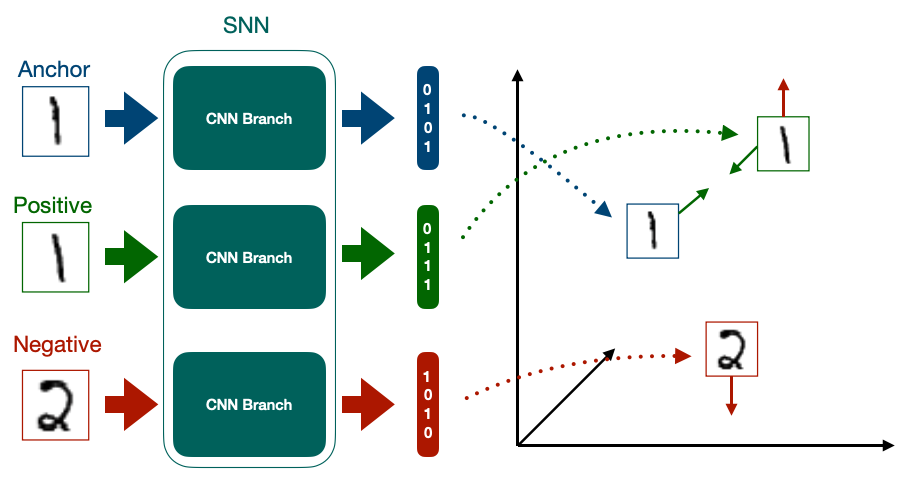

# Imports

In [ ]:
import sys 
sys.path.append('/content/Person-Re-Id-Dataset')

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import timm

import torch.nn.functional as F 
from torch import nn 
from torch.utils.data import Dataset, DataLoader 

from skimage import io
from sklearn.model_selection import train_test_split 

from tqdm import tqdm 

# Configurations

In [ ]:
#define configuratons to make later parts easier 
#define the paths 
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

#Declare the batch size 
BATCH_SIZE = 32
#define learning rate
LR = 0.001
#define epochs
EPOCHS = 15

#define gpu
DEVICE = 'cuda'

In [ ]:
#read in the csv file 
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [ ]:
#read the images 
row = df.iloc[11]

#display anchor image, positive image and negative image
A_im = io.imread(DATA_DIR + row.Anchor)
P_im = io.imread(DATA_DIR + row.Positive)
N_im = io.imread(DATA_DIR + row.Negative)

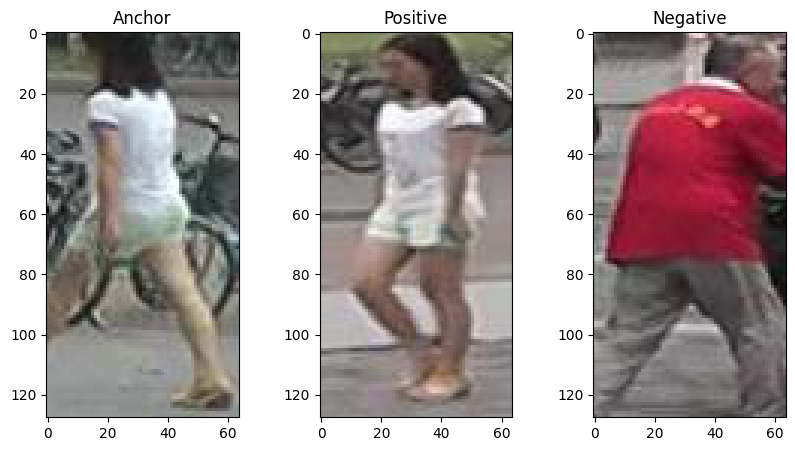

In [ ]:
#plot the images 
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(10,5))

ax1.set_title("Anchor")
ax1.imshow(A_im)

ax2.set_title("Positive")
ax2.imshow(P_im)

ax3.set_title("Negative")
ax3.imshow(N_im)

In [ ]:
#split data set into train and test sets
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

# Create APN Dataset 

In [ ]:
#create a class and methid format for dataset 
class APN_Dataset(Dataset):
  
  def __init__(self,df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    #display anchor image, positive image and negative image
    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    #convert to torch tensors
    A_img = torch.from_numpy(A_img).permute(2, 0, 1)/255.0
    P_img = torch.from_numpy(P_img).permute(2,0,1)/255.0
    N_img = torch.from_numpy(N_img).permute(2,0,1)/255.0

    return A_img, P_img, N_img


In [ ]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset: {len(trainset)}")
print(f"Size of validset: {len(validset)}")

Size of trainset: 3200
Size of validset: 800


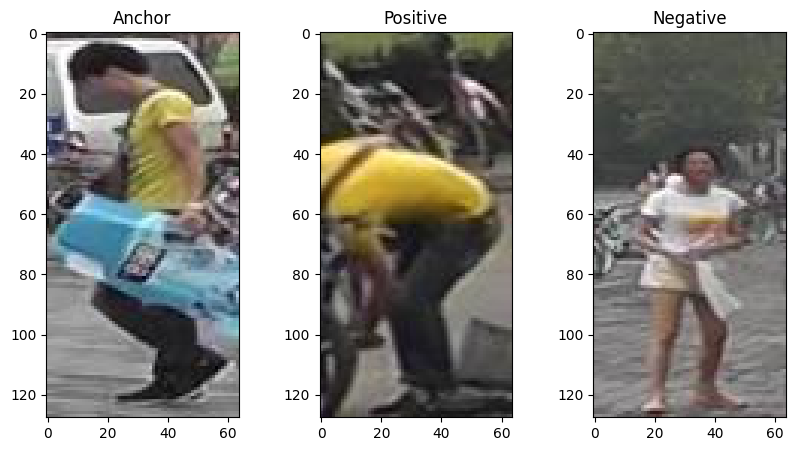

In [ ]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [ ]:
#Load the dataset into batches 
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [ ]:
#print the shape of one image batch
for A,P,N in trainloader:
  break;
    
print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model 

In [ ]:
class APN_Model(nn.Module):
    def __init__(self, emb_size=512):
        super(APN_Model, self).__init__()

        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
        self.efficientnet.classifier = nn.Linear(
            in_features=self.efficientnet.classifier.in_features, out_features=emb_size
        )

    def forward(self, images):
        embeddings = self.efficientnet(images)
        return embeddings


In [ ]:
model = APN_Model()
model.to(DEVICE)

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size

# Create Train and Eval function

In [ ]:
def train_fn(model, dataloader, optimizer, criterion):

  model.train() # ON Dropout
  total_loss = 0.0

  for A,P,N in tqdm(dataloader):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(dataloader)


In [ ]:
def eval_fn(model, dataloader, criterion):

  model.eval() # OFF Dropout
  total_loss = 0.0

  with torch.no_grad():
    for A,P,N in tqdm(dataloader):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

    return total_loss/len(dataloader)

In [ ]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss: 
    torch.save(model.state_dict, 'best_model.pt')
    best_valid_loss = valid_loss
    print("SAVED_WEIGHTS_SUCCESS")

  print(f"EPOCHS: {i+1} train_loss: {train_loss} valid_loss: {valid_loss}")

100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 1 train_loss: 0.4580990171432495 valid_loss: 0.34486679673194887


100%|██████████| 25/25 [00:02<00:00, 10.46it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 2 train_loss: 0.22097023911774158 valid_loss: 0.2614321157336235


100%|██████████| 25/25 [00:03<00:00,  7.99it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 3 train_loss: 0.10703142426908016 valid_loss: 0.20142565935850143


100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 4 train_loss: 0.07670075304806233 valid_loss: 0.14973696380853652


100%|██████████| 25/25 [00:02<00:00, 10.20it/s]


EPOCHS: 5 train_loss: 0.059991251453757284 valid_loss: 0.17148269712924957


100%|██████████| 25/25 [00:03<00:00,  8.15it/s]


EPOCHS: 6 train_loss: 0.05136493474245071 valid_loss: 0.16870683014392854


100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 7 train_loss: 0.06522552885115146 valid_loss: 0.12258635580539703


100%|██████████| 25/25 [00:02<00:00, 10.32it/s]


EPOCHS: 8 train_loss: 0.038132918030023576 valid_loss: 0.1371994808316231


100%|██████████| 25/25 [00:02<00:00,  9.16it/s]


EPOCHS: 9 train_loss: 0.05509628184139728 valid_loss: 0.16648348569869995


100%|██████████| 25/25 [00:02<00:00,  9.34it/s]


EPOCHS: 10 train_loss: 0.060989204645156864 valid_loss: 0.1873158657550812


100%|██████████| 25/25 [00:02<00:00, 10.43it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 11 train_loss: 0.06370668023824692 valid_loss: 0.10480801105499267


100%|██████████| 25/25 [00:02<00:00, 10.39it/s]


EPOCHS: 12 train_loss: 0.023963336907327173 valid_loss: 0.1442304790019989


100%|██████████| 25/25 [00:03<00:00,  7.81it/s]


EPOCHS: 13 train_loss: 0.03511070489883423 valid_loss: 0.13571113616228103


100%|██████████| 25/25 [00:02<00:00, 10.28it/s]


EPOCHS: 14 train_loss: 0.02276651866734028 valid_loss: 0.1587003067135811


100%|██████████| 25/25 [00:02<00:00, 10.29it/s]

EPOCHS: 15 train_loss: 0.045879564210772515 valid_loss: 0.13914047300815582


# Get Anchor Embeddings

In [ ]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR +i)
      A = torch.from_numpy(A).permute(2,0,1)/255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())
    
    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

  return df_enc

In [ ]:
#model.load_state_dict(torch.load('/content/best_model.pt'))
def_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [00:40<00:00, 98.70it/s] 


In [ ]:
def_enc.to_csv('database.csv', index = False)
def_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.519253,-0.295875,0.294553,0.559664,-1.118048,-1.119824,0.180600,-0.508435,-0.179970,...,-0.092422,1.557950,0.639478,-1.168983,0.686295,-0.332885,-0.211174,0.498423,0.394804,0.462623
1,1420_c3s3_061978_03.jpg,-0.331268,-0.368364,0.156126,0.580263,-1.165755,-1.095828,0.186815,-0.502856,-0.068228,...,-0.254867,1.574968,0.448629,-1.114538,0.684703,-0.370144,-0.183976,0.506626,0.347611,0.437351
2,1420_c5s3_062565_05.jpg,-0.403061,-0.336689,0.130809,0.558458,-1.206779,-1.109707,0.173316,-0.570048,-0.041889,...,-0.180011,1.730551,0.548007,-1.128963,0.680632,-0.351228,-0.255130,0.500769,0.342911,0.443899
3,1420_c6s3_085592_04.jpg,-0.199374,-0.157221,0.079347,0.651823,-0.998261,-1.026625,0.284902,-0.069799,-0.204754,...,-0.097459,0.799090,0.261540,-0.766201,0.790737,-0.568650,0.038263,0.629057,0.367515,0.335568
4,0663_c5s3_085987_03.jpg,1.208807,0.477180,0.288882,-0.060149,-0.877014,-0.865691,0.543158,0.806964,-0.580486,...,-0.373603,-1.174183,0.358046,0.281710,0.309793,-0.425881,-0.175523,0.105849,-0.224013,-1.094240


# Inference

In [ ]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T))
  return dist


In [ ]:
idx = 10
img_name = def_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0 ,1) / 255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [ ]:
anc_enc_arr = def_enc.iloc[:,1:].to_numpy()
anc_img_names = def_enc['Anchor']

In [ ]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i : i +1, :])
  distance = np.append(distance, dist)

In [ ]:
closest_idx = np.argsort(distance)

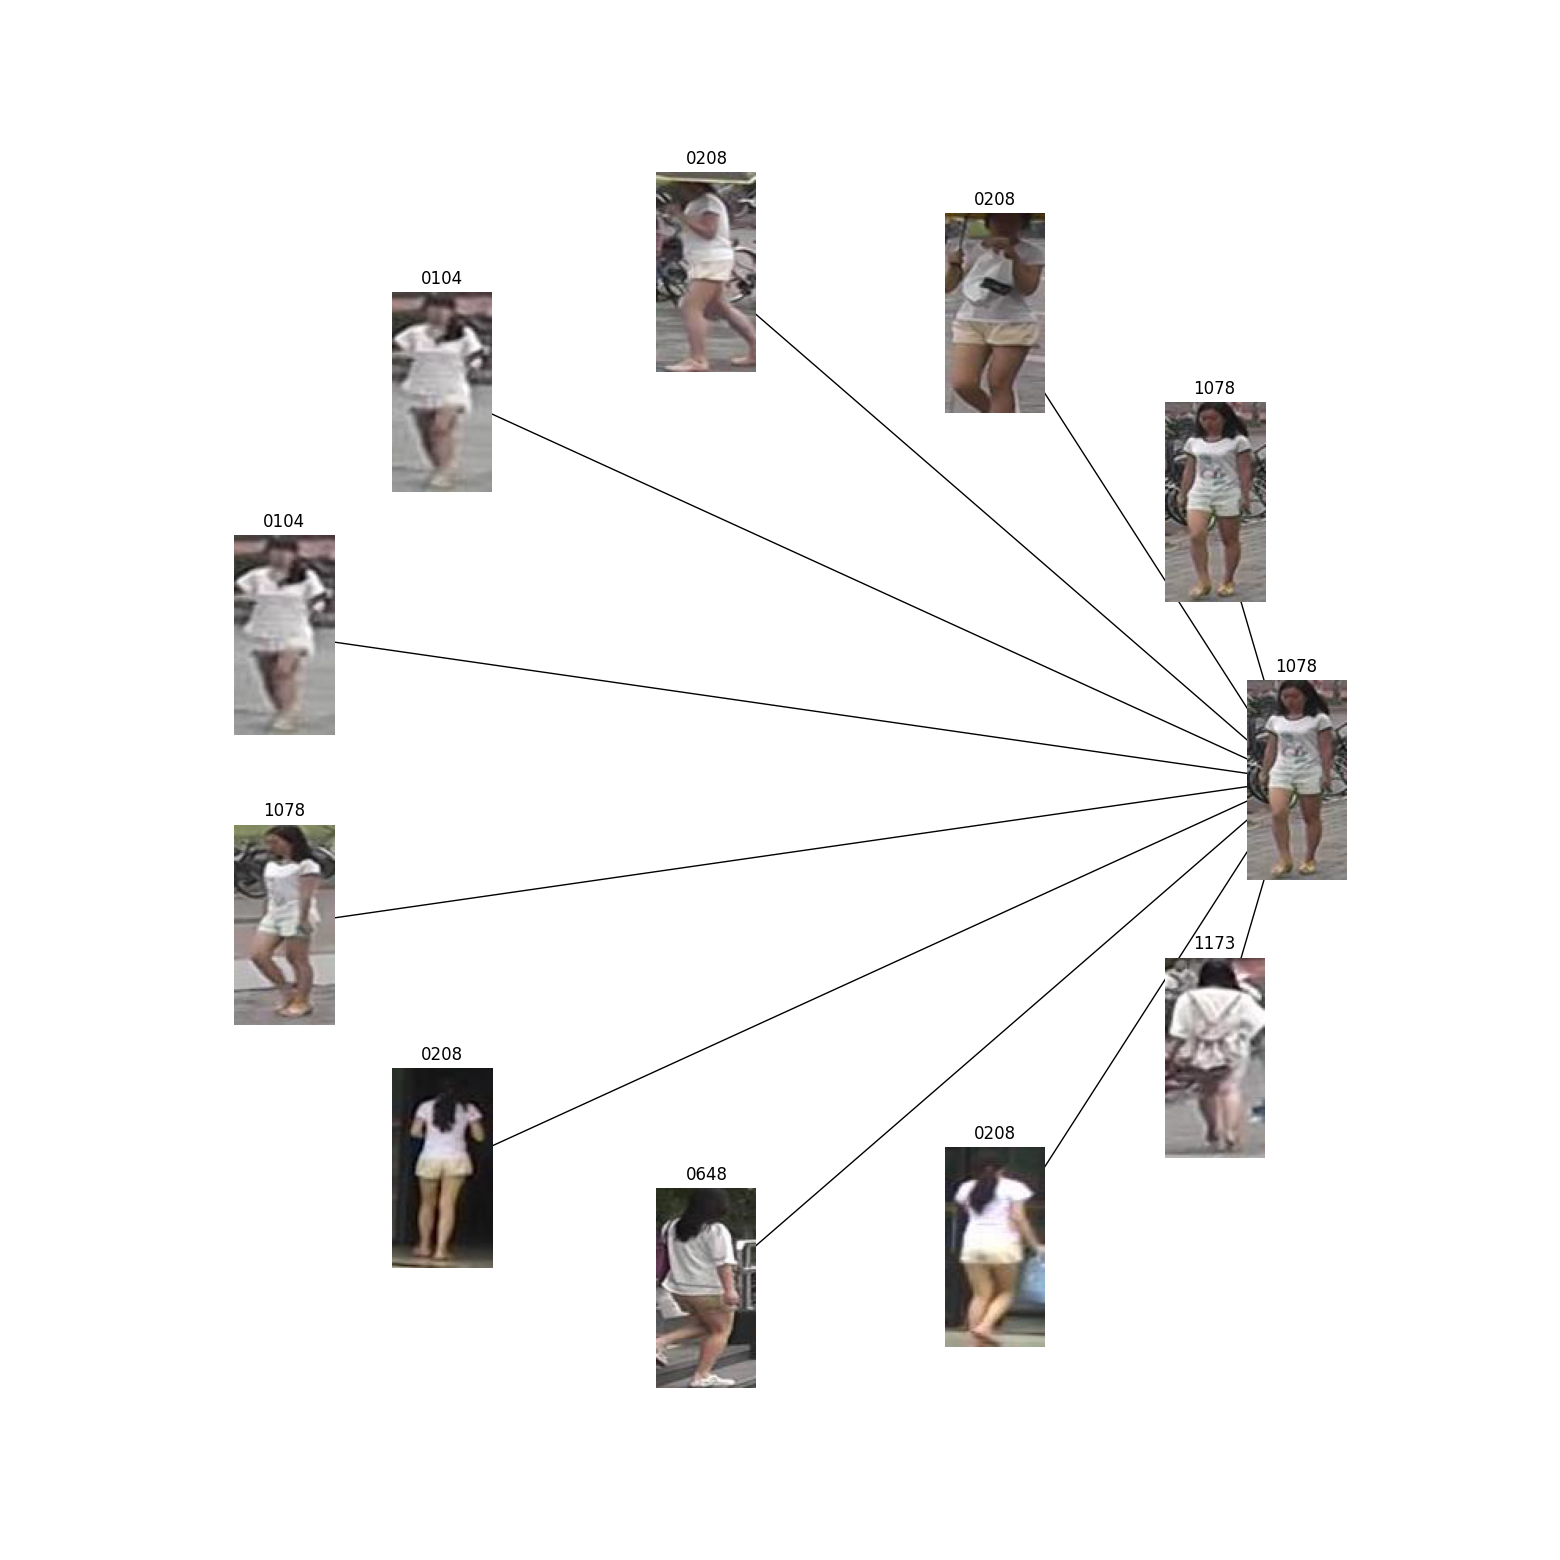

In [ ]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 10);